<a href="https://colab.research.google.com/github/Pikarz/tirocinio_infostud/blob/main/models/ARMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARMA: 22/09/23
Training del modello univariato ARMA sui dati di Infostud ```phoenixws_average```

# Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


# ARMA
Il codice è preso dalla seguente repository:

https://github.com/Anomaly-Detection-Research/arma-arima/blob/master/ARMA.ipynb

L'implementazione del notebook precedente aveva focalizzato la propria attenzione sull'identificazione dei presunti outliers, ovvero quei punti in cui i valori ```residuals```, che rappresentano la differenza tra i dati e la predizione del modello, sono al di fuori di un certo range _accettabile_ calcolato in funzione dell'iperparametro ```threshold```.

Di seguito i cambiamenti del notebook precedente rispetto all'implementazione originale:
- Modifica della funzione  ```plot_residuals``` per far sì che essa individui e mostri le anomalie (outliers)
- Implementazione della funzione ```get_ARMA_params``` per effettuare la grid search sui parametri AR e MA minimizzando l'errore quadratico medio.

L'implementazione di questo notebook, invece, prende in considerazione le anomalie ground-truth del modello e si focalizza sul calcolo delle metriche precisione, recall e F1, migrando quindi da un ambiente unsupervised a uno supervised.

In particolare:
- Ho aggiunto i campi relativi ai valori ground-truth del modello (training, validation e testing)
- Ho implementato la funzione ```evaluate_binary_classification()``` atta a calcolare i valori di precision, recall e F1
- Ho apportato qualche modifica a ```plot_residuals``` cosicché vengano plottate anche le ground-truth anomalies.
- Ho aggiornato la funzione ```get_ARMA_params``` cosicché essa restituisca gli iperparametri ```(P, Q, best_threshold)``` che massimizzano la metrica F1.
- Ho aggiornato la funzione ```print_stats``` cosicché essa stampi il numero di ground-truth anomalies

In [ ]:
 ### This function is required to be able to plot in colab using plotly. It needs to be run in each plotting cell.

 def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [ ]:
#ref: https://www.youtube.com/watch?v=IcxMywGiWUc
import warnings
import itertools
import pandas
import math
import sys
import plotly.graph_objs as go
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.metrics import precision_score, recall_score, f1_score
init_notebook_mode(connected=True)

In [ ]:
class ARMA:
    def __init__(self, p,q):
        self.p = p
        self.q = q

    # Setters
    def set_p(self,p):
        self.p=p

    def set_q(self,q):
        self.q=q

    def set_training_data_time(self, time):
        self.training_data_time = time

    def set_validation_data_time(self, time):
        self.validation_data_time = time

    def set_testing_data_time(self, time):
        self.testing_data_time = time

    def set_validation_data_set(self,data):
        self.validation_data_set = data

    def set_testing_data_set(self,data):
        self.testing_data_set = data

    def set_training_data_set(self,data):
        self.training_data = data
        self.Z = data - np.mean(data)
        self.Z.shape = (len(data),1)

    # New set methods to be able to use the supervised settings
    def set_training_ground_truth_data_set(self, data):
      self.training_ground_truth_data_set = data

    def set_testing_ground_truth_data_set(self, data):
      self.testing_ground_truth_data_set = data

    def set_validation_ground_truth_data_set(self, data):
      self.validation_ground_truth_data_set = data

    # Model
    def shock(self,mean,std):
        return np.random.normal(mean, std, 1)
#         return 0

    def calculate_AR_normal_matrix_x_row(self,data,t,mean,std):
        row = np.zeros((1,self.p+1))
        j = 0
        for i in range(t-self.p,t):
            if i < 0:
                row[0][j] = 0
            else:
                row[0][j] = data[i]
            j+=1
        row[0][-1] = self.shock(mean,std)
        return row

    def calculate_AR_weights(self):
        normal_matrix = np.zeros((len(self.training_data),self.p+1))
        mean = np.mean(self.Z)
        std = np.std(self.Z, ddof=1)
        for i in range(0,len(self.training_data)):
            normal_matrix[i] = self.calculate_AR_normal_matrix_x_row(self.Z,i,mean,std)

        normal_matrix_tanspose = normal_matrix.transpose()
        self.AR_weights = np.dot(np.dot(np.linalg.pinv(np.dot(normal_matrix_tanspose,normal_matrix)),normal_matrix_tanspose),self.Z)


    def get_AR_prediction(self,data_set):
        self.calculate_AR_weights()
        self.AR_prediction = np.zeros((np.max(data_set.shape),1))
        mean = np.mean(data_set)
        std = np.std(data_set, ddof=1)
        Z = np.array(data_set)
        Z.shape = (np.max(Z.shape),1)
        Z = Z - mean
        for i in range(0,np.max(Z.shape)):
            self.AR_prediction[i] = np.dot(self.calculate_AR_normal_matrix_x_row(Z, i, mean, std), self.AR_weights)

        self.AR_prediction = self.AR_prediction.transpose()[0] + mean
        return self.AR_prediction

    def get_previous_q_values(self,data,t):
        previous_q = np.zeros(self.q)
        j = 0
        for i in range(t-self.q,t):
            if i < 0:
                previous_q[j] = 0
            else:
                previous_q[j] = data[i]
            j+=1
        return previous_q

    def get_MA_prediction(self,data_set):
        self.MA_prediction = np.zeros(np.max(data_set.shape))
        Z = np.array(data_set)
        Z.shape = (np.max(Z.shape),1)
        for i in range(0,np.max(Z.shape)):
            self.MA_prediction[i] = np.average(self.get_previous_q_values(Z, i))

        return self.MA_prediction

    def calculate_AR_MA_normal_matrix_x_row(self,t):
        row = np.zeros((1,2))
        row[0][0] = self.MA_prediction[t]
        row[0][1] = self.AR_prediction[t]
        return row

    def calculate_AR_MA_weights(self):
        self.get_MA_prediction(self.training_data)
        self.get_AR_prediction(self.training_data)
        normal_matrix = np.zeros((len(self.training_data),2))

        for i in range(0,len(self.training_data)):
            normal_matrix[i] = self.calculate_AR_MA_normal_matrix_x_row(i)

        normal_matrix_tanspose = normal_matrix.transpose()
        self.weights = np.dot(np.dot(np.linalg.pinv(np.dot(normal_matrix_tanspose,normal_matrix)),normal_matrix_tanspose),self.training_data)

#         print(self.weights)
#         #normalizing weigts
#         total = self.weights[0] + self.weights[1]
#         self.weights[0] = self.weights[0]/total
#         self.weights[1] = self.weights[1]/total
#         print(self.weights)

    def get_prediction(self, data_set):
        self.calculate_AR_MA_weights()

        self.get_MA_prediction(data_set)
        self.get_AR_prediction(data_set)
        Z = np.array(data_set)
        Z.shape = (np.max(Z.shape),1)
        self.prediction = np.zeros((np.max(Z.shape),1))
        for i in range(0,np.max(Z.shape)):
            self.prediction[i] = np.dot(self.calculate_AR_MA_normal_matrix_x_row(i), self.weights)

        self.prediction = self.prediction.transpose()[0]
        return self.prediction

    # Diagnostics and identification messures
    def mse(self,values,pridicted):
        error = 0.0
        for i in range(0,len(values)):
            error += (values[i] - pridicted[i])**2
        return error/len(values)

    def get_mse(self, data, prediction):
        return self.mse(data,prediction)

    def plot_autocorrelation(self, data_set, lag):
        autocorrelations = np.zeros(lag)
        autocorrelations_x = np.arange(lag)
        autocorrelations[0] = 1.0
        for i in range(1,lag):
            autocorrelations[i] = np.corrcoef(data_set[i:],data_set[:-i])[0,1]

        trace = {"x": autocorrelations_x,
                 "y": autocorrelations,
                 'type': 'bar',
                 "name": 'Autocorrelation',
                }

        traces = [trace]
        layout = dict(title = "Autocorrelation",
                  xaxis = dict(title = 'Lag'),
                  yaxis = dict(title = 'Autocorrelation')
                 )
        fig = dict(data=traces, layout=layout)
        iplot(fig)

    def plot_partial_autocorrelation(self, data_set, lag):
        pac = np.zeros(lag)
        pac_x = np.arange(lag)

        residualts = data_set
        slope, intercept = np.polyfit(data_set,residualts,1)
        estimate = intercept + slope*data_set
        residualts = residualts - estimate
        pac[0] = 1
        for i in range(1,lag):
            pac[i] = np.corrcoef(data_set[:-i],residualts[i:])[0,1]

            slope, intercept = np.polyfit(data_set[:-i],residualts[i:],1)
            estimate = intercept + slope*data_set[:-i]

            residualts[i:] = residualts[i:] - estimate

        trace = {"x": pac_x,
                 "y": pac,
                 'type': 'bar',
                 "name": 'Partial Autocorrelation',
                }

        traces = [trace]
        layout = dict(title = "Partial Autocorrelation",
                  xaxis = dict(title = 'Lag'),
                  yaxis = dict(title = 'Partial Autocorrelation')
                 )
        fig = dict(data=traces, layout=layout)
        iplot(fig)

    def calculate_disjoint_subsets(self, residual, labels, upper_bound, lower_bound):
      # Calculate boolean arrays for different conditions
      tp = np.diag(((residual > upper_bound) | (residual < lower_bound)) & labels)
      fp = np.diag(((residual > upper_bound) | (residual < lower_bound)) & ~labels)
      tn = np.diag((residual < upper_bound) & (residual > lower_bound) & labels)
      fn = np.diag((residual < upper_bound) & (residual > lower_bound) & ~labels)
      print(residual[tp].shape)
      return tp, fp, tn, fn

    # nuova funzione che oltre a plottare i residui plotta anche le rispettive ground-truth anomalies
    def plot_residuals(self, data_set, prediction, time, labels, threshold):
      x = time
      residual = data_set - prediction
      mean = np.ones(len(data_set)) * np.mean(residual)
      std = np.std(residual, ddof=1)

      upper_bound = mean + threshold * std
      lower_bound = mean - threshold * std
      trace_upper_bound = {
          "x": x,
          "y": upper_bound,
          "mode": 'lines',
          "name": 'Anomaly upper bound'
      }
      trace_lower_bound = {
          "x": x,
          "y": lower_bound,
          "mode": 'lines',
          "name": 'Anomaly lower bound'
      }

      true_positives, false_positives, false_negatives, true_negatives = self.calculate_disjoint_subsets(residual, labels, upper_bound, lower_bound)

      trace_true_positives = {
          "x": x[true_positives],
          "y": residual[true_positives],
          "mode": 'markers',
          "name": 'True Positives',
          "marker": {"color": 'green', "size": 7}
      }

      trace_false_positives = {
          "x": x[false_positives],
          "y": residual[false_positives],
          "mode": 'markers',
          "name": 'False Positives',
          "marker": {"color": 'red', "size": 7}
      }

      trace_false_negatives = {
          "x": x[false_negatives],
          "y": residual[false_negatives],
          "mode": 'markers',
          "name": 'False Negatives',
          "marker": {"color": 'purple', "size": 7}
      }

      trace_true_negatives = {
          "x": x[true_negatives],
          "y": residual[true_negatives],
          "mode": 'markers',
          "name": 'True Negatives',
          "marker": {"color": 'blue', "size": 7}
      }

      traces = [trace_upper_bound, trace_lower_bound, trace_true_positives, trace_false_positives, trace_false_negatives, trace_true_negatives]

      layout = dict(
          title="Residual",
          xaxis=dict(title='Time'),
          yaxis=dict(title='Residual'),
          legend=dict(
              font=dict(
                  size=24  # Set the desired font size
              )
          ),
          width=1500,  # Set the width in pixels
          height=850  # Set the height in pixels
      )

      fig = dict(data=traces, layout=layout)
      iplot(fig)
      print("Standard Deviation of Residuals: " + str(std))
      print("Mean of Residuals: " + str(np.mean(residual)))



    def plot_data(self, data_set, time):
        mean = np.mean(data_set)
        means = np.ones(len(data_set))*mean
        trace_value = {"x": time,
                     "y": data_set,
                     "mode": 'lines',
                     "name": 'value'}

        trace_mean = {"x": time,
                         "y": means,
                         "mode": 'lines',
                         "name": 'mean'}
        traces = [trace_value,trace_mean]
        layout = dict(title = "Values with mean",
                      xaxis = dict(title = 'Time'),
                      yaxis = dict(title = 'Value')
                     )
        fig = dict(data=traces, layout=layout)
        iplot(fig)

        normalized_data = data_set - mean
        trace_value = {"x": time,
                     "y": normalized_data,
                     "mode": 'lines',
                     "name": 'value'}
        traces = [trace_value]
        layout = dict(title = "After removing mean",
                      xaxis = dict(title = 'Time'),
                      yaxis = dict(title = 'Value')
                     )
        fig = dict(data=traces, layout=layout)
        iplot(fig)


    def print_stats(self, data, prediction, labels):
        print("Mean Square Error : " + str(self.mse(data,prediction)))
        print("Mean of real values : " + str(np.mean(data)))
        print("Standard Deviation of real values : " + str(np.std(data, ddof=1)))
        print("Mean of predicted values : " + str(np.mean(prediction)))
        print("Standard Deviation of predicted values : " + str(np.std(prediction, ddof=1)))
        print("Number of data points : " + str(len(data)))
        print("Number of ground-truth anomalies : " + str(np.count_nonzero(labels)))


    def plot_result(self, time, data, prediction, labels, threshold=None):
        data.shape = (1,np.max(data.shape))
        data = data[0]
        trace_real = {"x": time,
                     "y": data,
                     "mode": 'lines',
                     "name": 'Real value'}
        trace_predicted = {"x": time,
                         "y": prediction,
                         "mode": 'lines',
                         "name": 'Predicted value'}
        traces = [trace_real,trace_predicted]
        layout = dict(title = "Training Data Set with ARMA("+str(self.p)+","+str(self.q)+")",
                      xaxis = dict(title = 'Time'),
                      yaxis = dict(title = 'Value'),
                      width=1500,  # Set the width in pixels
                      height=700,
                      legend=dict(
                          font=dict(
                              size=24  # Set the desired font size
                          )
                      ),
                     )
        fig = dict(data=traces, layout=layout)
        iplot(fig)
        self.print_stats(data,prediction, labels)

        self.plot_residuals(data, prediction, time, labels, threshold)
        precision, recall, f1 = self.evaluate_binary_classification(data, prediction, labels, threshold=threshold)
        print("Metrics:")
        print("\tPrecision:", precision)
        print("\tRecall:", recall)
        print("\tF1-score:", f1)


    def evaluate_binary_classification(self, data, predictions, ground_truth, threshold=0.5):
        data.shape = (1,np.max(data.shape))
        data = data[0] # data è una matrice (n \times n). Nell'implementazione originale, quando viene effettuato il plot dei dati, riferiscono a data[0]. Non ho ben capito però la matrice cosa rappresenta.
        residuals = data - predictions
        mean = np.mean(residuals)
        std = np.std(residuals, ddof=1)
        upper_bound = mean + threshold * std
        lower_bound = mean - threshold * std

        is_outlier = ((residuals > upper_bound) | (residuals < lower_bound))

        precision = precision_score(ground_truth, is_outlier, zero_division=0)
        recall = recall_score(ground_truth, is_outlier, zero_division=0)
        f1 = f1_score(ground_truth, is_outlier, zero_division=0)

        return precision, recall, f1

# ARMA: Grid-search
Nella cella seguente è implementata la funzione ```get_ARMA_params``` che effettua una grid-search del modello con vari iperparametri ```(P,Q)```. Per ogni coppia ```(P,Q)``` la funzione valuta le metriche di precisione, recall ed F1 del modello a diversi thresholds.

La funzione restituisce gli iperparametri ```(P, Q, best_threshold)``` che massimizzano lo score F1 nella grid-search.



In [ ]:
import numpy as np

def get_ARMA_params(training_set_values, training_set_time, validation_set_values, validation_set_time, training_ground_truth, validation_ground_truth, epochs=10, thresholds=None):
    arma_model = ARMA(1, 1)
    arma_model.set_training_data_set(training_set_values)
    arma_model.set_training_data_time(training_set_time)
    arma_model.set_training_ground_truth_data_set(training_ground_truth)

    arma_model.set_validation_data_set(validation_set_values)
    arma_model.set_validation_data_time(validation_set_time)
    arma_model.set_validation_ground_truth_data_set(validation_ground_truth)

    if not thresholds:
      thresholds = np.linspace(0.1, 5.0, num=10)  # Grid search through threshold values

    P = 0
    Q = 0
    best_f1 = 0
    best_threshold = 0

    for i in range(1, epochs):
        arma_model.set_p(i)
        for j in range(1, epochs):
            arma_model.set_q(j)

            for threshold in thresholds:
                prediction = arma_model.get_prediction(arma_model.validation_data_set)
                precision, recall, f1 = arma_model.evaluate_binary_classification(
                    arma_model.validation_data_set,
                    prediction,
                    arma_model.validation_ground_truth_data_set,
                    threshold=threshold
                )
                #print("arma(" + str(i) + "," + str(j) + ") - Threshold: " + str(threshold) + " - F1: " + str(f1) + " - Precision: " + str(precision) + " - Recall: " + str(recall), end=',\n')
                if f1 > best_f1:
                    P = i
                    Q = j
                    best_f1 = f1
                    best_threshold = threshold
                    print(f"\tCurrent best: ({P}, {Q}). Threshold: {threshold}. F1: {f1}")

    print("Optimal metrics at P = " + str(P) + ", Q = " + str(Q) + ", Threshold = " + str(best_threshold))
    return P, Q, best_threshold


# Estrazione dati e labels

In [ ]:
dataset_path = './drive/My Drive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/average_dataset/phoenixws_average_2020-06-13.csv'
labels_path = './drive//My Drive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/average_dataset/phoenixws_average_2020-06-13_gt.csv'

In [ ]:
def calculate_anomaly_percentage(ground_truth):
    num_anomalies = np.sum(ground_truth)
    total_samples = len(ground_truth)
    anomaly_percentage = (num_anomalies / total_samples) * 100
    return anomaly_percentage

In [ ]:
import pandas as pd

columns = ['phoenixws_average_'+str(i) for i in range(12)]
df = pd.read_csv(dataset_path, names=columns)
df.index.name = 'time'

In [ ]:
# null values per column
df.isna().sum()

phoenixws_average_0     17190
phoenixws_average_1     17170
phoenixws_average_2     17002
phoenixws_average_3     24062
phoenixws_average_4      8356
phoenixws_average_5       154
phoenixws_average_6       131
phoenixws_average_7        32
phoenixws_average_8        10
phoenixws_average_9        35
phoenixws_average_10      233
phoenixws_average_11       10
dtype: int64

In [ ]:
df_monovariate = df['phoenixws_average_8'] # infostud's login service
nan_mask = df_monovariate.isna() # extract nan rows wrt the login service

In [ ]:
df_monovariate = pd.DataFrame(df_monovariate[~nan_mask]) # remove nan values

In [ ]:
labels = pd.read_csv(labels_path, names=['label'], header=None)

In [ ]:
labels = labels[~nan_mask] # remove nan values from labels

In [ ]:
labels.index.name = 'time'
df_monovariate

phoenixws_average_8
time                      
0                93.719837
1               101.692592
2                96.113135
3               108.615769
4               115.352263
...                    ...
48332           100.255517
48333            91.695597
48334            91.920055
48335           108.358627
48336           101.564899

[48327 rows x 1 columns]

In [ ]:
labels

label
time        
0      False
1      False
2      False
3      False
4      False
...      ...
48332  False
48333  False
48334  False
48335  False
48336  False

[48327 rows x 1 columns]

# ARMA - Normalize

In [ ]:
# normalizzazione
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
average_df_normalized = pd.DataFrame(scaler.fit_transform(df_monovariate), index=df_monovariate.index, columns=df_monovariate.columns)

# ARMA - Plot dati e anomalie

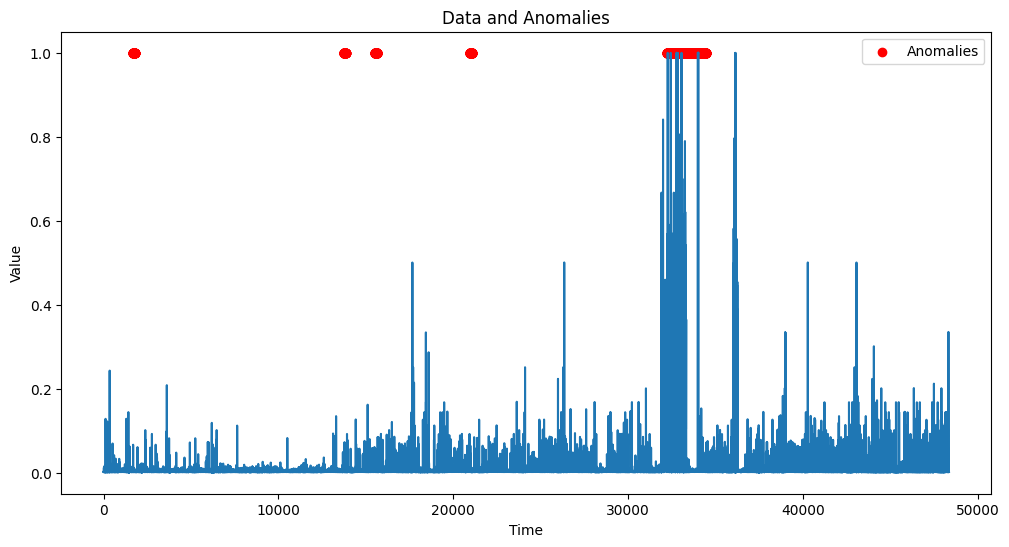

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

merged_df = pd.merge(average_df_normalized, labels, on="time", how="inner")
highlighted_points = merged_df[merged_df["label"] == 1]
plt.figure(figsize=(12, 6))
plt.plot(average_df_normalized)
plt.scatter(highlighted_points.index, highlighted_points["label"], color="red", label="Anomalies")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Data and Anomalies")
plt.show()

# ARMA - suddivisione in training, validation e test set

In [ ]:
dataframe = average_df_normalized
time = dataframe.index
values = dataframe.values

training_ratio = 0.5
validation_ratio = 0.182

# Deviding the data set to training, validation, testing parts
training_end = int(math.floor(len(values)*training_ratio))
training_set_values = np.array(values[0:training_end])
training_set_time = np.array(time[0:training_end])
training_ground_truth = np.array(labels[0:training_end])

validation_start = training_end
validation_end = int(math.floor(len(values)*(training_ratio + validation_ratio)))
validation_set_values = np.array(values[validation_start:validation_end])
validation_set_time = np.array(time[validation_start:validation_end])
validation_ground_truth = np.array(labels[validation_start:validation_end])

testing_start = validation_end
testing_end = len(values)
testing_set_values = np.array(values[testing_start:testing_end])
testing_set_time = np.array(time[testing_start:testing_end])
testing_ground_truth = np.array(labels[testing_start:testing_end])

In [ ]:
print(training_end)
print(validation_end-training_end)
print(testing_end-validation_end)

24163
8796
15368


In [ ]:
# Calculate and print the percentages of anomalies in each set
training_anomaly_percentage = calculate_anomaly_percentage(training_ground_truth)
validation_anomaly_percentage = calculate_anomaly_percentage(validation_ground_truth)
testing_anomaly_percentage = calculate_anomaly_percentage(testing_ground_truth)

print("Percentage of anomalies in the training set:", training_anomaly_percentage)
print("Percentage of anomalies in the validation set:", validation_anomaly_percentage)
print("Percentage of anomalies in the test set:", testing_anomaly_percentage)

Percentage of anomalies in the training set: 2.011339651533336
Percentage of anomalies in the validation set: 8.594815825375171
Percentage of anomalies in the test set: 9.59135866736075


# ARMA - Ricerca iperparametri

In [ ]:
configure_plotly_browser_state()

# grid-search to find the hyperparameters that maximize the F1 score
P, Q, threshold = get_ARMA_params(training_set_values, training_set_time, validation_set_values, validation_set_time, training_ground_truth, validation_ground_truth, epochs = 30)

	Current best: (1, 1). Threshold: 0.1. F1: 0.15586874211190577
	Current best: (1, 1). Threshold: 0.6444444444444445. F1: 0.7482100238663485
	Current best: (1, 25). Threshold: 0.6444444444444445. F1: 0.7488207547169812
	Current best: (2, 25). Threshold: 0.6444444444444445. F1: 0.7489711934156379
	Current best: (18, 6). Threshold: 0.6444444444444445. F1: 0.7491166077738515
	Current best: (20, 8). Threshold: 0.6444444444444445. F1: 0.7502944640753828
Optimal metrics at P = 20, Q = 8, Threshold = 0.6444444444444445


# ARMA - Training

In [ ]:
# hyperparameters that maximized the F1 score
P,Q = 20,8
threshold = 0.6444444444444445

arma_model = ARMA(P,Q)

# Stack the training and validation values vertically (axis=0) since validation is not needed anymore
combined_values = np.concatenate((training_set_values.ravel(), validation_set_values.ravel()), axis=0)
combined_time = np.concatenate((training_set_time, validation_set_time), axis=0)
combined_ground_truth = np.concatenate((training_ground_truth, validation_ground_truth), axis=0)

# Combined data as new training set
new_training_set_values = combined_values
new_training_set_time = combined_time
new_training_ground_truth = combined_ground_truth

In [ ]:
arma_model.set_training_data_set(new_training_set_values)
arma_model.set_training_data_time(new_training_set_time)
arma_model.set_training_ground_truth_data_set(new_training_ground_truth)

arma_model.set_testing_data_set(testing_set_values)
arma_model.set_testing_data_time(testing_set_time)
arma_model.set_testing_ground_truth_data_set(testing_ground_truth)

testing_prediction = arma_model.get_prediction(arma_model.testing_data_set)

In [ ]:
configure_plotly_browser_state()
arma_model.plot_result(arma_model.testing_data_time, arma_model.testing_data_set, testing_prediction, arma_model.testing_ground_truth_data_set, threshold=threshold)

Mean Square Error : 0.0023154740779843717
Mean of real values : 0.01720260749073215
Standard Deviation of real values : 0.08137465824776569
Mean of predicted values : 0.017083624154632937
Standard Deviation of predicted values : 0.06874178977096039
Number of data points : 15368
Number of ground-truth anomalies : 1474
(366,)


Standard Deviation of Residuals: 0.048120791747129465
Mean of Residuals: 0.00011898333609921855
Metrics:
	Precision: 0.33212341197822143
	Recall: 0.24830393487109906
	F1-score: 0.2841614906832298


# Conclusioni: 22/09/23


ARMA fornisce una soluzione discreta simile a quella di OC-SVM, nonostante sul segnale più vuoto avesse riportato risultati notevolmente migliori $\approx 50\%$ F1